In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
cd "/content/drive/MyDrive/Spring_2023_Project/COMS_572_Source_Code/MNIST"

/content/drive/MyDrive/Spring_2023_Project/COMS_572_Source_Code/MNIST


In [15]:
## load package
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
from sklearn.model_selection import train_test_split

In [16]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [17]:
# load build-in dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [18]:
## reshape and normalize data
x_train = x_train.reshape(60000, 28, 28, 1)
x_test = x_test.reshape(10000, 28, 28, 1)
y_train = y_train.reshape(60000,)
y_test = y_test.reshape(10000,)


In [19]:
y_train_one_hot = tf.keras.utils.to_categorical(y_train)
y_test_one_hot = tf.keras.utils.to_categorical(y_test)

In [20]:
train_arr_75 = [tf.image.grayscale_to_rgb(tf.image.resize(img, (75, 75))) for img in x_train]
train_arr_75 = np.array(train_arr_75)
train_arr_75.shape

(60000, 75, 75, 3)

In [21]:
test_arr_75 = [tf.image.grayscale_to_rgb(tf.image.resize(img, (75, 75))) for img in x_test]
test_arr_75 = np.array(test_arr_75)
test_arr_75.shape

(10000, 75, 75, 3)

In [22]:
x_split_train, x_split_validation, y_split_train, y_split_validation = train_test_split(train_arr_75,y_train_one_hot, train_size=0.8, random_state=1)

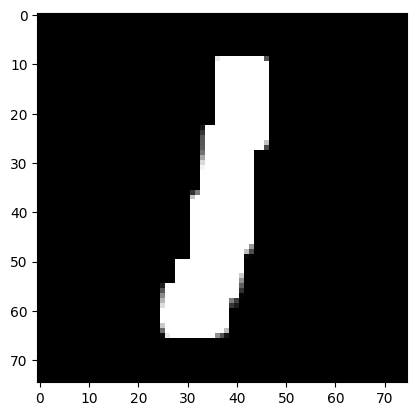

In [23]:
plt.imshow(x_split_train[0])

In [24]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3)

In [25]:
model = tf.keras.models.load_model('epoch10_stage_1_MNIST_VGG_build_model.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 2, 2, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                        

In [26]:
model.layers[0].trainable=True
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 2, 2, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                        

In [27]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=opt,
      metrics=[tf.keras.metrics.CategoricalAccuracy()]
  )

with tf.device('/device:GPU:0'):
  history2 = model.fit(x_split_train, y_split_train, validation_data=(x_split_validation, y_split_validation), epochs = 10, verbose=1, callbacks=[reduce_lr])

Epoch 1/2
1500/1500 [==============================] - 152s 90ms/step - loss: 0.1196 - categorical_accuracy: 0.9668 - val_loss: 0.1399 - val_categorical_accuracy: 0.9603 - lr: 1.0000e-04
Epoch 2/2
1500/1500 [==============================] - 134s 90ms/step - loss: 0.0407 - categorical_accuracy: 0.9882 - val_loss: 0.2203 - val_categorical_accuracy: 0.9463 - lr: 1.0000e-04


In [28]:
def loss_diagnostics(history):
    # plot loss
    plt.plot(history.history['loss'], color='blue', label='Train')
    plt.plot(history.history['val_loss'], color='orange', label='Validation')
    plt.legend()


In [29]:
def accuracy_diagnostics(history):
    plt.plot(history.history['categorical_accuracy'], color='blue', label='Train')
    plt.plot(history.history['val_categorical_accuracy'], color='orange', label='Validation')
    plt.legend()

In [31]:
history2.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])

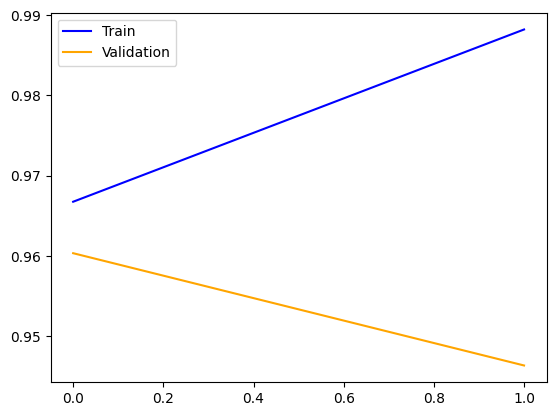

In [32]:
accuracy_diagnostics(history2)

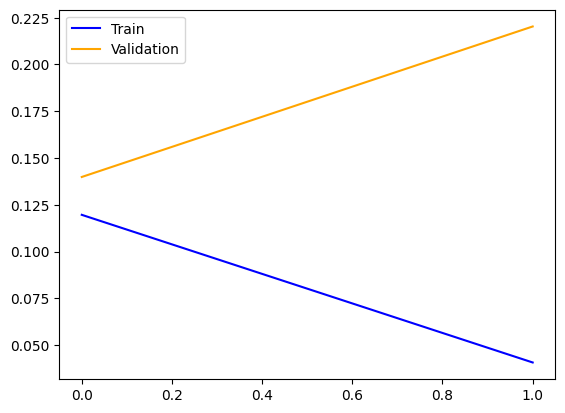

In [33]:
loss_diagnostics(history2)

In [34]:
stage_2_lr = history2.history['lr']
stage_2_lr = np.array(stage_2_lr)

In [35]:
np.savetxt('epoch10_stage_2_lr.txt', stage_2_lr, fmt='%f')

In [36]:
model.save('epoch10_stage_2_MNIST_VGG_build_model.h5')